# Applying a Gradient Free Sampling Based Approach For Training Deep Spiking Neural Networks

## Computational Neuroscience basics

The following excerpts are from the "Computational Neuroscience" coursera course from the University of Washington by Rajesh P.N.Rao and Adrienne Fairhall.

### Receptive Fields

#### Descriptive Model

This model describes *what* a receptive field is. There are two main take-aways:
- Encoding - how a neuron reacts to stimuli
- Decoding - inferring information from neurons

A receptive field can take many forms in order to react to a wide range of different stimuli. Here are two receptive fields used in our sense of sight:

![image](images/ReceptiveField1.PNG "Receptive Field")

This is a receptive field found in the retina. It responds to a bright spot surrounded by darkness

![image](images/ReceptiveField2.PNG "Receptive Field")

This is a receptive field found in the primary visual cortext (which recieves an image from the retina). It responds to a bright strip surrounded by darkness.

#### Mechanistic Model

This model describes *how* a receptive field works. We simulate the behaviour of either single neurons or networks of many neurons.

![image](images/ReceptiveField3.PNG "Receptive Field")

The above image shows how the receptive field in the visual cortex are formed using the retinas receptive field as building blocks. It is evident that multiple receptive fields from the latter feed into a single receptive field of the former.

#### interpretive Model

This model describes *why* a receptive field works the way it does, and the computational principles underlying these operations. 

![image](images/ReceptiveField4.PNG "Receptive Field")

Above we have multiple examples of receptive fields that may be present in the visual cortex. From them we now want an explanation as to why they are the way they are and what computational advantages there are to having such fields.

We can consider an image $ I $ being reconstructed into $ \hat{I} $ with a linear sum of receptive fields: 

$$ \hat{I} = \sum_iRF_ir_i $$

Where $ r_i $ are the neural respones. The main idea is to find the minimal $ RF_i $ that minimise the squared pixelwise errors between $ I $ and $ \hat{i} $ while being as independent as possible. This is the so called 'efficient coding algorithm'. Running this algortithm on randomised sets of $ RF_i $ surprisingly yield the same receptive fields found in the human body.

### Electrical Properties of Neurons

![image](images/IdealNeuron.PNG "Neuron")
image by Eric Chudler, UW

Above is an image of an ideal neuron showing its basic structure and it's input and output. Multiple input from other neurons' axons enter the dentrites, and in in the case of a spike, a signal travels down the axon into the dentrites of any other neurons' Dendrites via synapses.

![image](images/IonicChannel.PNG "Ion Channel")

Spikes are generated due to the control of ionic channels, that allow or block certain ions to enter or exit the neuron. This in turn causes changes in the voltage potential of the cell.

![image](images/Spike.PNG "Spike")
image by Eric Chudler, UW

Above is an illustration of how the changes in the neurons ionic makeup create the signature spike shape.

![image](images/ElectricalSynapse.PNG "Eletrical Synapse")
![image](images/ChemicalSynapse.PNG "Chemical Synapse")

These are the two types of synapse that the brain uses to transmits signals between neurons, the left being an electrical synapse (That uses a gap junction to form a potential difference between the two neurons) and the right being a chemical one (That uses neurotransmitters to open ionic channels in the postsynaptic neuron). 

These synapses are responsible for memory and learning in the brain, using something named *Hebbian Plasticity*. If a neuron repeatedly takes part in the firing of another neuron, then the synapse between then is strengthened. This means that spikes occur more readily in the latter neuron when the former one fires in the future (i.e there will be higher excitory postsynaptic potential (EPSP)). This is called *long Term Potentiation* (LTP). The opposite is also true, and this phenomena is called *Long Term Depression* (LTD).

LTP and LTD are dependent on the relative timings of the presynaptic and postsynaptic neurons. If the input spike is before the output spike then there is LTP, and in the converse case there is LTD.

![image](images/LTP.PNG "LTP")
![image](images/LTD.PNG "LTD")

A common equation used to represent Spike-Dependent Timing Plasticity (SDTP) is given by: 

$$\Delta w = \sum_{t_{pre}} \sum_{t_{post}} W(t_{post}-t_{pre})$$

$$W(\Delta t) = \begin{cases}
A_{pre} e^{-\Delta t/\tau_{pre}} & \Delta t>0 \\
A_{post} e^{\Delta t/\tau_{post}} & \Delta t<0
\end{cases}$$

Essentially we are summing a function of the difference between pre- and post- synaptic spikes to get the synaptic weight change. This is highly innefecient to run over all synapses and so we have equivalent formulations given by the Brian code below

C:\Users\tejas\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


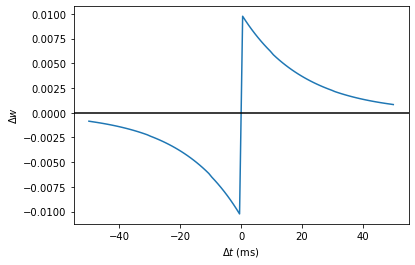

In [1]:
from brian2 import *
%matplotlib inline

start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(G, H,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             apre += Apre
             w = w+apost
             ''',
             on_post='''
             apost += Apost
             w = w+apre
             ''')
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');

Below is a script showing how the firing rate of a neuron that has 100 inputs from *poisson spiking* neurns (which we will cover later on) changes as we reduce the time constant $ \tau $ of the reciving neuron:

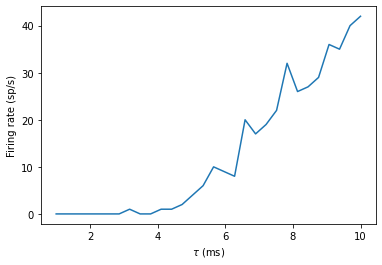

In [3]:
from brian2 import *
%matplotlib inline

# remember, this is here for running separate simulations in the same notebook
start_scope()
# Parameters
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
# Range of time constants
tau_range = linspace(1, 10, 30)*ms
# Use this list to store output rates
output_rates = []
# Iterate over range of time constants
for tau in tau_range:
    # Construct the network each time
    P = PoissonGroup(num_inputs, rates=input_rate)
    eqs = '''
    dv/dt = -v/tau : 1
    '''
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
    S = Synapses(P, G, on_pre='v += weight')
    S.connect()
    M = SpikeMonitor(G)
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(M.num_spikes/second)
# And plot it
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

### Neural Encoding

This is trying to describe how a stimulus casues a pattern of respone, i.e $ p(response|stimulus) $.

Neural representation of information is when we plot the neural response (e.g average firing rate) against a certain stimulus parameter (e.g sound volume, frequency etc).

#### Basic Encoding Models

we have basic encoding models that would give us the average firing rate given a stimulus (i.e $ p(response|stimulus) \rightarrow r(t) $

##### Linear Response

The most basic theory we could put forward is that the response at each time is linearly dependent on the stimulus at any given moment.

$$ r(t) = \phi s(t) \; or \; \phi s(t-\tau) $$

But this cannot be the whole picture. In reality we need to take into account previous inputs as well the current one to calculate the response of a neuron. 

$$ r(t) = \sum_{k=0}^ns_{t-k}f_k \: or \: r(t) = \int^t_{-\infty}s(t-\tau)f(\tau)d\tau $$

where we have the current stimulus $ s $ as well as the stimulus $ k $ steps into the past weighted by $ f $, which is a function of $ k $. We notice here that when formed into an integral it is very similar to convolution for a Linear Time Invariant (LTI) filter (i.e $ r(t) = s*f $). This system is known as a *temporal filter* as it is dependent on relative time. You can also have spatial filters:

$$ r(x, y) = \sum_{x'=0,y'=-n}^ns_{x-x',y-y'}f_{x',y'} \: or \: \int_{-\infty}^\infty s(x-x',y-y')f(x',y')dx'dy' $$

Where the response at a certain point is effected by the response of its surrounding points on a 2-D plane.

To complete our conceptualisation we must take into account that firing rates cannot be negative, and so we must introduce a non-linear function that achieves this. We can write this full equation as:

$$ r(t) = g(\int^t_{-\infty}s(t-\tau)f(\tau)d\tau) $$

Where $ g $ is a non-linear function

In general you can think of a stimulus going through miltiple blocks, that each have thier own function. We can model these blocks like so:

![image](images/EncodingModel.png "Encoding Model")

We have the input stimulus going into a feature (i.e our linear filter), and then into an I/O function (i.e out non-linear function), which then outputs the firing rate of that specific neuron.

#### Selecting Features

When we are plotting the response given the stimulus, we want to further generalise it for many stimuli to see what the response is for all inputs. Something that is commonly used for this stimulus is gaussian white noise. This noise makes calculations easy since it is gaussian in all dimensions, and is also equally represnted in all frequencies equally.

In order to plot this we discretise the stimuli into n timepoints, and record it as an n-dimentional vector which can be plotted on an n-dimentional plot.

![image](images/FeatureSelection.png "Feature Selection")

Here we can see deiscretised simuli from a gaussian white noise source being plottied on an n-dimentional plot. WE can then select the specific stimuli that cause a spike, and label them the spike conditional distribution ($ p(stimulus|spike) $). We can then take the average of this distribution to get the Spike-Triggered Average (STA), which would indicate what type of stimulus would cause a spike in general (i.e the feature of this neuron that acts as the "linear filter").

Shown below is an example of how a STA would be computed from a set of data in practice. Essentially you find the points at which a spike occurs in a set of data, and save the part of the stimulus that preceded it. Then to get the STA you simply find the average of these stimuli sections. It shows that this particular neuron responds to a sharp increase icrease in the stimulus parameter, that shortly thereafter declines to its resting value.

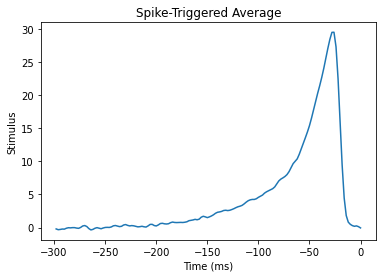

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
import sys

def compute_sta(stim, rho, num_timesteps):
    """Compute the spike-triggered average from a stimulus and spike-train.
    
    Args:
        stim: stimulus time-series
        rho: spike-train time-series
        num_timesteps: how many timesteps to use in STA
        
    Returns:
        spike-triggered average for specified number of timesteps before spike"""
    
    sta = np.zeros((num_timesteps,))

    # This command finds the indices of all of the spikes that occur
    # after 300 ms into the recording.
    spike_times = rho[num_timesteps:].nonzero()[0] + num_timesteps
    
    # Fill in this value. Note that you should not count spikes that occur
    # before 300 ms into the recording.
    num_spikes = len(spike_times)
    
    # Compute the spike-triggered average of the spikes found.
    # To do this, compute the average of all of the vectors
    # starting 300 ms (exclusive) before a spike and ending at the time of
    # the event (inclusive). Each of these vectors defines a list of
    # samples that is contained within a window of 300 ms before each
    # spike. The average of these vectors should be completed in an
    # element-wise manner.
    # 
    # Your code goes here.
    
    for i in spike_times:
        for j in range(num_timesteps):
            sta[j] = sta[j] + stim[i-num_timesteps+j]

    sta = sta/num_spikes
    
    return sta

sys.path.append(os.path.realpath('datasets/c1p8.pickle'))
FILENAME = 'datasets/c1p8.pickle'

with open(FILENAME, 'rb') as f:
    data = pickle.load(f)
    
stim = data['stim']
rho = data['rho']
    

# Fill in these values
# number in ms
sampling_period = 2
num_timesteps = 150

sta = compute_sta(stim, rho, num_timesteps)

time = (np.arange(-num_timesteps, 0) + 1) * sampling_period

plt.plot(time, sta)
plt.xlabel('Time (ms)')
plt.ylabel('Stimulus')
plt.title('Spike-Triggered Average')

plt.show()

Previously we though of the linear filtering carried out by a neuron as the convolution of the stimulus with the feature, but since we can now think of them both as n-dimentional vectors we can no simply find the projection of the stimulus onto the projection instead.

So now we know that we can obtain the feature of the neuron, we can now find the non-linear I/O function to find a function of the firing rate for a neuron. To do this we make use of *Bayes rule*:

$$ p(spike|stimulus) \rightarrow p(spike|s_1) $$

where $ s_1 $ is the projection of the sitmulus onto the feature $ f $ (i.e $ s*f $)

$$ p(spike|s_1) = \frac{p(s_1|spike)p(spike)}{p(s_1)} $$

where $ p(s_1|spike) $ is the spike conditional distribution we had earlier and $ p(s_1) $ is the prior probability distribution of the stimulus. for the final value $ p(spike) $ we simply calculate is independent of the stimulus, it is a constant scaling factor.

If we do not want to use white noise as a stimulus, and instead want to use a natural one, it is still possible, but it is not guaranteed to converge to a seingle point. The way we do this is to check all possibe features, and find the one which has a distribution that is most varied from its spike-conditional distribution. A good expriment, will ideally have $ p(s_1|spike) $ be as different as possible to $ p(s_1) $. For the former we can simply take the values of $ s_1 $ wherever a spike occured, and compare it to the general distribution of $ s_1 $. To calculate the difference between these two values we make use of the *Kullback-Leibler Divergence*:

$$ D_{KL}(p(s_f|spike),p(s_f)) = \int p(s_f|spike)log_2(\frac{p(s_f|spike)}{p(s_f)}) ds $$

![image](images/FeatureSelection2.png "Feature Selection 2")
Sharpee, Rust and Bialek, Neural Computation (2004)
Image from Fairhall, Barreiro, Shea-Brown (2012)

Maximising this integral will give us the most variance between the two functions, and making sure that we make the best possible choice of feature.

#### More Complex Models

This of course is a very basic view of a spiking network. We can add further complexities that add more blocks to our diagram and make it a more accurate depiction of real neurons. For example, neurons have been observed to have a refractory period, meaning that they have a short "cool down" period after they spike. This can be simulated using yet another filter in our diagram. Furthermore, it is possible that neurons are effected by, and have an effect on, other neurons in the network. One such more complex diagram is shown below:

![image](images/CoupledSpiking.png "Coupled Spiking")
Pillow et al., Nature (2008)

This system impliments $ r(t) = g(f_1*s + h_1*r_1 + h_2*r_2 + ...) $.

#### Spiking Patterns

Spiking can be thought of as independent *bernoulli trials*, where the probability of a spike occuring in any given time bin is $ p $. Lets take a recording of time $ T $, and divide it into $ n $ time bins of size $ \delta t $. We can say that the distribution of the spikes is given by a *binomial distribution*. Therefore the probability of $ k $ spike occuring in $ n $ bins is given by: $ p_n[k] = \binom knp^k(1-p)^{n-k} $. The mean is $ k\bar = np $ and the variance is $ \sigma ^2 = np(1-p) $.

However, as we decrease the size of the time bins, the spiking pattern tends to a limit which is *poisson spiking*. The equations for this kind of spiking  are:

Probability of k spikes in time T: $ p_T[k] = (rT)^k e^{-\frac{rT}{k!}} $

Mean: $ k\bar = rT $

Variance: $ \sigma ^2 = rT $

Fano-factor: $ F = 1 $

Interval distribution: $ p(T) = re^{-rT} $

Above we have stated something called the *Fano-factor*. This is essentially just the ratio between the mean and the variance of a distribution. Since for a perfect poission distribution this is always 1, we use this as a test to see wether it truly is poisson or not.

Below is a quick brian script that shows a simple neuron governed by the differential equation $ \frac{dv}{dt} = \frac{1-v}{tau} $ with a brief refractory period:

C:\Users\tejas\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


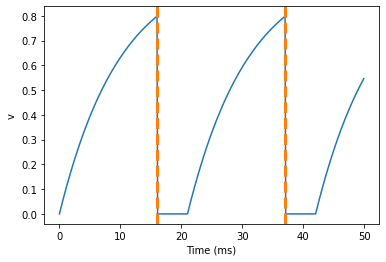

In [2]:
from brian2 import *
%matplotlib inline

start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

### Neural Decoding

This is trying to describe what a response tells us about the stimulus that caused it, i.e $ p(stimulus|response) $.

## Linear Regression model

### Basic Concepts

Using concepts from: https://medium.com/datathings/neural-networks-and-backpropagation-explained-in-a-simple-way-f540a3611f5e 
and
https://www.youtube.com/watch?v=GIsg-ZUy0MY

In general when working on Machine Learning (ML) algorithms we have a different problem to traditional programming concepts. You have two main steps; learning what the internal state of a function should be based on training data intputs and outputs, and then using your predicted state to estimate the output for previously unseen inputs.

![image](images/ML_BD.png "Machine Learning Block Diagram")

In order to for the algorthm to learn what the state of a function should be, it follows this general structure:

- Model Initialisation

For this we usually have the general structure of what the function should look like. For example we can have  linear expression such as: 

$$ apple yield  = w11 \times temp + w12 \times rainfall + w13 \times humidity + b1 $$
$$ orange yield = w21 \times temp + w22 \times rainfall + w23 \times humidity + b2 $$

Notice that we have multiple unknowns known as weights ($w_x$) and biases ($b_y$). These are the values we need to learn to make an accurate model. For out initial initialisation we can theoretically choose any number, and so we usually randomise them to begin with.

- Forward Propogation

Once we have our initialised model, we need to check how close it is to the actualy mdoel we are aiming to learn. In order to do this we first run the model with the training inputs and record the outputs our system generates

- Loss Function

We then create a loss function to calculate the difference between the outputs our model generated and the actual training outputs. A commonly used function for this is known as Mean-Square Error (MSE), which we will cover later on.

- Optimisation

This is the step where we improve our model to be closer to the actual one. The most common method is called gradient descent, for which we need to differentiate. Once we have a loss function we can differentiate it w.r.t w and b (i.e $\frac{dl}{dw}$ and $\frac{dl}{db}$). This essentially gives us how the loss changes when we change each of these variables.

- Backward Propogation

Since we obviously want to reduce the loss of our model, we change the unknowns so that they move against the loss gradient. In other words:

If a gradient element is positive (blue arrow):

- increasing the element's value slightly will increase the loss.
- decreasing the element's value slightly will decrease the loss

If a gradient element is negative (red arrow):

- increasing the element's value slightly will decrease the loss.
- decreasing the element's value slightly will increase the loss.

![image](images/LossGradient.png "Loss Gradient")

We can then calculate the loss with these new variables and continue iterating over the previous steps to get a lower and lower loss

### Concrete Example

Here is a following example using built in functions within the pytorch package:

In [1]:
import numpy as np
import torch
import torch.nn as nn

We are trying to estimate the effect of temperature, rainfall and humidity on the growth of apples and oranges. We are modeling this relationship by the following linear equation: 

$$ apple yield  = w11 \times temp + w12 \times rainfall + w13 \times humidity + b1 $$
$$ orange yield = w21 \times temp + w22 \times rainfall + w23 \times humidity + b2 $$

First we create our input and output training data using numpy (since numpy is usable with a wider range of packages and is msot likely how you will be recieving the data), and then convert it into PyTorch tensors. As you can see we have included the recorded data of 15 cities.

In [2]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], [91, 88, 64], [87, 134, 58], 
                   [102, 43, 37], [69, 96, 70], [73, 67, 43], 
                   [91, 88, 64], [87, 134, 58], [102, 43, 37], 
                   [69, 96, 70], [73, 67, 43], [91, 88, 64], 
                   [87, 134, 58], [102, 43, 37], [69, 96, 70]], 
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70], [81, 101], [119, 133], 
                    [22, 37], [103, 119], [56, 70], 
                    [81, 101], [119, 133], [22, 37], 
                    [103, 119], [56, 70], [81, 101], 
                    [119, 133], [22, 37], [103, 119]], 
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

Then we want to break up the data into multiple `Dataset`s so that we can work with them separately. This is most helpful when we are working with larger datasets, so break up the computation we are doing (e.g. to access the first three elements of the input and output data we can simply do `train_ds[0:3]`). We also create a DataLoader, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data. (e.g. we can now iterate through the data in chunks of 5 randomly chosen tuples like so:

`
for xb, yb in train_dl:
    print(xb)
    print(yb)
`

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Define dataset
train_ds = TensorDataset(inputs, targets)

# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In order to forward propogate, we need to create an inital weight matrix. To do this we can make use PyTorch yet again. What we are doing here is creating a matrix of 3 weights and 2 biases, as is required in out linear equation. We can access these values by using `model.weight` and `model.bias`, or simply `model.parameters`.

In [5]:
# Define model
model = nn.Linear(3, 2)

Then we can forward proopgate by by feeding our input into our randomly generated model. Essentially what is happening is a matrix multiplication, to end up with a matrix of results.

![image](images/Model.png "Model")

In [6]:
# Generate predictions
preds = model(inputs)

Then finally we need a loss fuction to differentiate and improve our weight matrix. For this we can once again use PyTorch. What we are actually calculating is the Mean-Square Error (MSE) between the training results and our predictions.

$$ MSE = \frac{1}{N}\sum_{i=1}^N(f_i-y_i)^2 $$

Where $N$ is the number of datapoints, and $f_i$ and $y_i$ are the values returned by our model and the actual output for each datapoint $i$ respectively.

In [7]:
# Import nn.functional
import torch.nn.functional as F

# Define loss function
loss_fn = F.mse_loss

loss = loss_fn(model(inputs), targets)

Next we want to carry out the optimisation step. For now we will use gradient descent as before. In PyTorch `optim.SGD` stands for stochastic gradient descent. Stochastic is used since we are using randomly selected databatches. We input the parameters we are trying to improve, and also the learning rate we want to implement.

In [8]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

Finally we can put it all together to make a training function. We run it for what we call multiple 'epochs', which essentially means iterations of training. Also we are using the `opt.step` and `opt.zero_grad` functions to update the weights and reset the gradients to zero. We could also do that manually by using the code:

`
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()
`

In [20]:
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl):
    
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        
        # Train with batches of data
        for xb,yb in train_dl:
            
            # 1. Generate predictions
            pred = model(xb)
            
            # 2. Calculate loss
            loss = loss_fn(pred, yb)
            
            # 3. Compute gradients
            loss.backward()
            
            # 4. Update parameters using gradients
            opt.step()
            
            # 5. Reset the gradients to zero
            opt.zero_grad()
        
        # Print the progress
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Now we can run our training algorithm for 100 epoch and check how much our error goes down. As is evident we end up with a model which generated outputs quite close to the actual outputs.

In [11]:
fit(100, model, loss_fn, opt, train_dl)

Epoch [10/100], Loss: 1049.9531
Epoch [20/100], Loss: 123.8482
Epoch [30/100], Loss: 172.0408
Epoch [40/100], Loss: 80.6848
Epoch [50/100], Loss: 161.8276
Epoch [60/100], Loss: 90.9157
Epoch [70/100], Loss: 9.1269
Epoch [80/100], Loss: 55.4193
Epoch [90/100], Loss: 53.5239
Epoch [100/100], Loss: 35.2748


In [12]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 59.1822,  71.3231],
        [ 79.9493,  97.6083],
        [120.8535, 138.9005],
        [ 31.9847,  41.6113],
        [ 91.6601, 111.1740],
        [ 59.1822,  71.3231],
        [ 79.9493,  97.6083],
        [120.8535, 138.9005],
        [ 31.9847,  41.6113],
        [ 91.6601, 111.1740],
        [ 59.1822,  71.3231],
        [ 79.9493,  97.6083],
        [120.8535, 138.9005],
        [ 31.9847,  41.6113],
        [ 91.6601, 111.1740]], grad_fn=<AddmmBackward>)

In [13]:
# Compare with targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

Now we can attempt to use an alternative optimisation technique for this dataset. Instead of gradient descent, we can try to use a random selection technique instead.

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], [91, 88, 64], [87, 134, 58], 
                   [102, 43, 37], [69, 96, 70], [73, 67, 43], 
                   [91, 88, 64], [87, 134, 58], [102, 43, 37], 
                   [69, 96, 70], [73, 67, 43], [91, 88, 64], 
                   [87, 134, 58], [102, 43, 37], [69, 96, 70]], 
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70], [81, 101], [119, 133], 
                    [22, 37], [103, 119], [56, 70], 
                    [81, 101], [119, 133], [22, 37], 
                    [103, 119], [56, 70], [81, 101], 
                    [119, 133], [22, 37], [103, 119]], 
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

# Define dataset
train_ds = TensorDataset(inputs, targets)

# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

model = nn.Linear(3, 2)
loss_fn = F.mse_loss
# Random sampling approach
#def opt(parameters, l_rate, xb, yb):
    # Checking the loss around w
    
    # Checking the loss around b
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl):
    
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        
        # Train with batches of data
        for xb,yb in train_dl:
            
            # 1. Generate predictions
            pred = model(xb)
            
            # 2. Calculate loss
            loss = loss_fn(pred, yb)
            
            # 3. Compute gradients
            loss.backward()
            
            # 4. Update parameters using gradients
            opt.step()
            
            # 5. Reset the gradients to zero
            opt.zero_grad()
        
        # Print the progress
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            
fit(100, model, loss_fn, opt, train_dl)

Epoch [10/100], Loss: 639.6415
Epoch [20/100], Loss: 448.8123
Epoch [30/100], Loss: 528.9656
Epoch [40/100], Loss: 197.5988
Epoch [50/100], Loss: 136.5398
Epoch [60/100], Loss: 87.9071
Epoch [70/100], Loss: 117.7878
Epoch [80/100], Loss: 48.2199
Epoch [90/100], Loss: 19.6031
Epoch [100/100], Loss: 21.6650


Now that we have a working example for a basic dataset, we would like to make an artificial model of a neual network. We will be starting with a network simulating the system which a scorpion uses to detect where a potential prey is located. It consists of receptor neurons that detect an oncoming wave at different times, and send inhibitory or exitory signals to the control neurons for it to successfully hunt. Below is a script showing how such a system can be simulated.

C:\Users\tejas\anaconda3\envs\brian_nn\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
WARNING    The expression "N_post / 2" divides two integer values. In previous versions of Brian, this would have used either an integer ("flooring") or a floating point division, depending on the Python version and the code generation target. In the current version, it always uses a floating point division. Explicitly ask for an  integer division ("//"), or turn one of the operands into a floating point value (e.g. replace "1/2" by "1.0/2") to no longer receive this warning. [brian2.parsing.bast.floating_point_division]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 144.00
Estimated angle (deg): 141.00


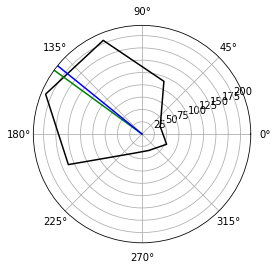

In [1]:
from brian2 import *
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Parameters
degree = 2 * pi / 360.
duration = 500*ms
R = 2.5*cm  # radius of scorpion
vr = 50*meter/second  # Rayleigh wave speed
phi = 144*degree  # angle of prey
A = 250*Hz
deltaI = .7*ms  # inhibitory delay
gamma = (22.5 + 45 * arange(8)) * degree  # leg angle
delay = R / vr * (1 - cos(phi - gamma))   # wave delay

# Inputs

# Wave (vector w)
time = arange(int(duration / defaultclock.dt) + 1) * defaultclock.dt
Dtot = 0.
w = 0.
for f in arange(150, 451)*Hz:
    D = exp(-(f/Hz - 300) ** 2 / (2 * (50 ** 2)))
    rand_angle = 2 * pi * rand()
    w += 100 * D * cos(2 * pi * f * time + rand_angle)
    Dtot += D
w = .01 * w / Dtot

# Rates from the wave
rates = TimedArray(w, dt=defaultclock.dt)

# Targets

# Leg mechanical receptors
tau_legs = 1 * ms
sigma = .01
eqs_legs = """
dv/dt = (1 + rates(t - d) - v)/tau_legs + sigma*(2./tau_legs)**.5*xi:1
d : second
"""
legs = NeuronGroup(8, model=eqs_legs, threshold='v > 1', reset='v = 0', refractory=1*ms, method='euler')
legs.d = delay
spikes_legs = SpikeMonitor(legs)

# Command neurons
tau = 1 * ms
taus = 1.001 * ms
wex = 7
winh = -2
eqs_neuron = '''
dv/dt = (x - v)/tau : 1
dx/dt = (y - x)/taus : 1 # alpha currents
dy/dt = -y/taus : 1
'''
neurons = NeuronGroup(8, model=eqs_neuron, threshold='v>1', reset='v=0', method='exact')
synapses_ex = Synapses(legs, neurons, on_pre='y+=wex')
synapses_ex.connect(j='i')
synapses_inh = Synapses(legs, neurons, on_pre='y+=winh', delay=deltaI)
synapses_inh.connect('abs(((j - i) % N_post) - N_post/2) <= 1')
target_spikes = SpikeMonitor(neurons)

real = Network(legs, spikes_legs, neurons, synapses_ex, synapses_inh, target_spikes)

real.run(duration, report='text')

nspikes = target_spikes.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
rmax = amax(nspikes)/duration/Hz
polar(concatenate((gamma, [gamma[0] + 2 * pi])),
      concatenate((nspikes, [nspikes[0]])) / duration / Hz,
      c='k')
axvline(phi, ls='-', c='g')
axvline(phi_est, ls='-', c='b')
show()

Now we want to create a model network and initialise is with random weights as we did before. Then once again we have an error function (using the circular mean to get the minimum angle between the real and modeled result). The problem is that we can now no longer make use of linear regression as an optimisation technique. So now we make use of the paper by Rohun Tripathi and Bharat Singh: https://arxiv.org/abs/2005.05955. We use a random sampling approach: 

$$ 
w_{i+1} =
\left\{
    \begin{array}{l}
      w_i \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: f(x,w_i) <= f(x,w_i+\Delta w_i)\\
      w_i+\Delta w_i \:\:\:\:\: f(x,w_i) > f(x,w_i+\Delta w_i)
    \end{array}
 \right.
$$

Where $ \Delta w_i $ is a small increment either before or after the previous guess.

So first for a single input angle we run our learning algorithm. We have the 8 leg neurons and the 8 control neurons for which we are trying to calculate the synaptic weights. Each pass we go through each synaptic weight and see wether increasing it or decreasing it reduces the loss funciton (thereby improving our model). This means that on each pass we are going through 64 synapses, and for each synapse we are running the simulation 3 times. This may lead to huge running costs for larger networks, but fortunately for this small example it doesn't take long to run. This method was surprisingly effective, getting very close even after the very first epoch!

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
initial:
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 144.00
Estimated angle (deg): -164.91
Error (deg): 51.09
epoch 0:
True angle (deg): 144.00
Estimated angle (deg): 144.03
Error (deg): 0.03
epoch 1:
True angle (deg): 144.00
Estimated angle (deg): 144.03
Error (deg): 0.03
epoch 2:
True angle (deg): 144.00
Estimated angle (deg): 144.03
Error (deg): 0.03
epoch 3:
True angle (deg): 144.00
Estimated angle (deg): 144.03
Error (deg): 0.03
final:
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 144.00
Estimated angle (deg): 144.03
Error (deg): 0.03


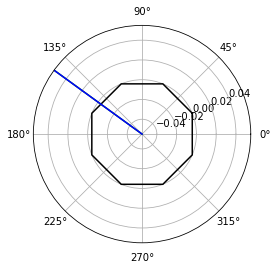

In [6]:
from brian2 import *
from brian2tools import *
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Parameters
degree = 2 * pi / 360.
duration = 500*ms
R = 2.5*cm  # radius of scorpion
vr = 50*meter/second  # Rayleigh wave speed
phi = 144*degree  # angle of prey
A = 250*Hz
deltaI = .7*ms  # inhibitory delay
gamma = (22.5 + 45 * arange(8)) * degree  # leg angle
delay = R / vr * (1 - cos(phi - gamma))   # wave delay

# Inputs

# Wave (vector w)
time = arange(int(duration / defaultclock.dt) + 1) * defaultclock.dt
Dtot = 0.
w = 0.
for f in arange(150, 451)*Hz:
    D = exp(-(f/Hz - 300) ** 2 / (2 * (50 ** 2)))
    rand_angle = 2 * pi * rand()
    w += 100 * D * cos(2 * pi * f * time + rand_angle)
    Dtot += D
w = .01 * w / Dtot

# Rates from the wave
rates = TimedArray(w, dt=defaultclock.dt)

# Targets

# Leg mechanical receptors
tau_legs = 1 * ms
sigma = .01
eqs_legs = """
dv/dt = (1 + rates(t - d) - v)/tau_legs + sigma*(2./tau_legs)**.5*xi:1
d : second
"""
fake_legs = NeuronGroup(8, model=eqs_legs, threshold='v > 1', reset='v = 0', refractory=1*ms, method='euler')
fake_legs.d = delay
fake_spikes_legs = SpikeMonitor(fake_legs)

# We use a Network object because later on we don't
# want to include these objects
leg_net = Network(fake_legs, fake_spikes_legs)
leg_net.run(duration, report ='text')
# And keep a copy of those spikes
spikes_i = fake_spikes_legs.i
spikes_t = fake_spikes_legs.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(8, spikes_i, spikes_t)

# Command neurons

model_weights = np.random.rand(64)

tau = 1 * ms
eqs_model = '''
dv/dt = (1-v)/tau : 1
'''

fake_neurons = NeuronGroup(8, model=eqs_model, threshold='v>1', reset='v=0', method='exact')
fake_synapses = Synapses(SGG, fake_neurons, 'weight : 1',  on_pre='v_post += weight')
fake_synapses.connect()
fake_synapses.weight = model_weights
fake_spikes = SpikeMonitor(fake_neurons)

fake = Network(SGG, fake_neurons, fake_synapses, fake_spikes)

# loss function

def abs_err(target, model):
    delta = abs(target - model)
    delta_min = abs(target - model - 360)
    delta_plu = abs(target - model + 360)
    
    return min(set([delta, delta_min, delta_plu]))

# storing origional state
fake.store()

# initial configuration
print('initial:')
fake.run(duration, report='text')
nspikes = fake_spikes.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
error = abs_err((phi/degree), (phi_est/degree))
print("Error (deg): %.2f" % error)
fake.restore()

l_rate = 0.05
e = 0
for epoch in range(4):
    p = 0
    for s in fake_synapses.weight:

        fake.run(duration)
        nspikes = fake_spikes.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        error = abs_err((phi/degree), (phi_est/degree))
        fake.restore()
        #print("error: %.2f" % error)

        # attempt adding learning rate
        new_weights = fake_synapses.weight
        fake_synapses.weight[p] += l_rate

        fake.run(duration)
        nspikes = fake_spikes.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        add_err = abs_err((phi/degree), (phi_est/degree))
        fake.restore()
        #print("add_err: %.2f" % add_err)

        # attempt subtracting learning rate
        new_weights = fake_synapses.weight
        fake_synapses.weight[p] -= l_rate

        fake.run(duration)
        nspikes = fake_spikes.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        sub_err = abs_err((phi/degree), (phi_est/degree))
        fake.restore()
        #print("sub_err: %.2f" % sub_err)

        min_err = min(set([error, add_err, sub_err]))

        if(min_err == add_err):
            fake_synapses.weight[p] += l_rate
        if(min_err == sub_err):
            fake_synapses.weight[p] -= l_rate

        # storing new initial state
        fake.store() 
        #print("min_err: %.2f" % min_err)
        
        p = p + 1   

    print('epoch %i:' % e)
    fake.run(duration)
    nspikes = fake_spikes.count
    phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
    print("True angle (deg): %.2f" % (phi/degree))
    print("Estimated angle (deg): %.2f" % (phi_est/degree))
    error = abs_err((phi/degree), (phi_est/degree))
    print("Error (deg): %.2f" % error)
    fake.restore()
    
    e = e + 1
    
    
# final configuration
print('final:')
fake.run(duration, report='text')
nspikes = fake_spikes.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
error = abs_err((phi/degree), (phi_est/degree))
print("Error (deg): %.2f" % error)
fake.restore()
    
rmax = amax(nspikes)/duration/Hz
polar(concatenate((gamma, [gamma[0] + 2 * pi])),
      concatenate((nspikes, [nspikes[0]])) / duration / Hz,
      c='k')
axvline(phi, ls='-', c='g')
axvline(phi_est, ls='-', c='b')
show()

Clearly this optimisation method does work for spiking neural networks, but what we have acheieved so far is to find the synaptic weights that will detect one particular angle. Let us see what happens when we use these weights to estimate the location of a prey at a different angle (It is notable that we did not need more than 2 epochs on average to largly minimise the loss function).

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
initial:
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 144.00
Estimated angle (deg): -105.07
Error (deg): 110.93
epoch 0:
True angle (deg): 144.00
Estimated angle (deg): -159.92
Error (deg): 56.08
epoch 1:
True angle (deg): 144.00
Estimated angle (deg): 150.84
Error (deg): 6.84
final:
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 144.00
Estimated angle (deg): 150.84
Error (deg): 6.84
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
with new angle:
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 25.00
Estimated angle (deg): 159.11
Error (deg): 134.11


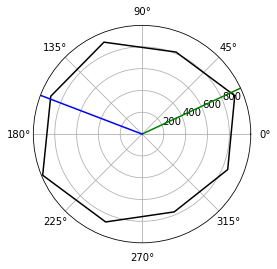

In [16]:
from brian2 import *
from brian2tools import *
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Parameters
degree = 2 * pi / 360.
duration = 500*ms
R = 2.5*cm  # radius of scorpion
vr = 50*meter/second  # Rayleigh wave speed
phi = 144*degree  # angle of prey
A = 250*Hz
deltaI = .7*ms  # inhibitory delay
gamma = (22.5 + 45 * arange(8)) * degree  # leg angle
delay = R / vr * (1 - cos(phi - gamma))   # wave delay

# Inputs

# Wave (vector w)
time = arange(int(duration / defaultclock.dt) + 1) * defaultclock.dt
Dtot = 0.
w = 0.
for f in arange(150, 451)*Hz:
    D = exp(-(f/Hz - 300) ** 2 / (2 * (50 ** 2)))
    rand_angle = 2 * pi * rand()
    w += 100 * D * cos(2 * pi * f * time + rand_angle)
    Dtot += D
w = .01 * w / Dtot

# Rates from the wave
rates = TimedArray(w, dt=defaultclock.dt)

# Targets

# Leg mechanical receptors
tau_legs = 1 * ms
sigma = .01
eqs_legs = """
dv/dt = (1 + rates(t - d) - v)/tau_legs + sigma*(2./tau_legs)**.5*xi:1
d : second
"""
fake_legs = NeuronGroup(8, model=eqs_legs, threshold='v > 1', reset='v = 0', refractory=1*ms, method='euler')
fake_legs.d = delay
fake_spikes_legs = SpikeMonitor(fake_legs)

# We use a Network object because later on we don't
# want to include these objects
leg_net = Network(fake_legs, fake_spikes_legs)
leg_net.run(duration, report ='text')
# And keep a copy of those spikes
spikes_i = fake_spikes_legs.i
spikes_t = fake_spikes_legs.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(8, spikes_i, spikes_t)

# Command neurons

model_weights = np.random.rand(64)

tau = 1 * ms
eqs_model = '''
dv/dt = (1-v)/tau : 1
'''

fake_neurons = NeuronGroup(8, model=eqs_model, threshold='v>1', reset='v=0', method='exact')
fake_synapses = Synapses(SGG, fake_neurons, 'weight : 1',  on_pre='v_post += weight')
fake_synapses.connect()
fake_synapses.weight = model_weights
fake_spikes = SpikeMonitor(fake_neurons)

fake = Network(SGG, fake_neurons, fake_synapses, fake_spikes)

# loss function

def abs_err(target, model):
    delta = abs(target - model)
    delta_min = abs(target - model - 360)
    delta_plu = abs(target - model + 360)
    
    return min(set([delta, delta_min, delta_plu]))

# storing origional state
fake.store()

# initial configuration
print('initial:')
fake.run(duration, report='text')
nspikes = fake_spikes.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
error = abs_err((phi/degree), (phi_est/degree))
print("Error (deg): %.2f" % error)
fake.restore()

l_rate = 0.05
e = 0
for epoch in range(2):
    p = 0
    for s in fake_synapses.weight:

        fake.run(duration)
        nspikes = fake_spikes.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        error = abs_err((phi/degree), (phi_est/degree))
        fake.restore()
        #print("error: %.2f" % error)

        # attempt adding learning rate
        fake_synapses.weight[p] += l_rate

        fake.run(duration)
        nspikes = fake_spikes.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        add_err = abs_err((phi/degree), (phi_est/degree))
        fake.restore()
        #print("add_err: %.2f" % add_err)

        # attempt subtracting learning rate
        fake_synapses.weight[p] -= l_rate

        fake.run(duration)
        nspikes = fake_spikes.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        sub_err = abs_err((phi/degree), (phi_est/degree))
        fake.restore()
        #print("sub_err: %.2f" % sub_err)

        min_err = min(set([error, add_err, sub_err]))

        if(min_err == add_err):
            fake_synapses.weight[p] += l_rate
        if(min_err == sub_err):
            fake_synapses.weight[p] -= l_rate

        # storing new initial state
        fake.store() 
        #print("min_err: %.2f" % min_err)
        
        p = p + 1   

    print('epoch %i:' % e)
    fake.run(duration)
    nspikes = fake_spikes.count
    phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
    print("True angle (deg): %.2f" % (phi/degree))
    print("Estimated angle (deg): %.2f" % (phi_est/degree))
    error = abs_err((phi/degree), (phi_est/degree))
    print("Error (deg): %.2f" % error)
    fake.restore()
    
    e = e + 1
    
    
# final configuration
print('final:')
fake.run(duration, report='text')
nspikes = fake_spikes.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
error = abs_err((phi/degree), (phi_est/degree))
print("Error (deg): %.2f" % error)
fake.restore()

# For new angle

phi = 25*degree  # angle of prey

# Wave (vector w)
time = arange(int(duration / defaultclock.dt) + 1) * defaultclock.dt
Dtot = 0.
w = 0.
for f in arange(150, 451)*Hz:
    D = exp(-(f/Hz - 300) ** 2 / (2 * (50 ** 2)))
    rand_angle = 2 * pi * rand()
    w += 100 * D * cos(2 * pi * f * time + rand_angle)
    Dtot += D
w = .01 * w / Dtot

# Rates from the wave
rates = TimedArray(w, dt=defaultclock.dt)

# Targets

# Leg mechanical receptors
tau_legs = 1 * ms
sigma = .01
eqs_legs = """
dv/dt = (1 + rates(t - d) - v)/tau_legs + sigma*(2./tau_legs)**.5*xi:1
d : second
"""
new_fake_legs = NeuronGroup(8, model=eqs_legs, threshold='v > 1', reset='v = 0', refractory=1*ms, method='euler')
new_fake_legs.d = delay
new_fake_spikes_legs = SpikeMonitor(new_fake_legs)

# We use a Network object because later on we don't
# want to include these objects
new_leg_net = Network(new_fake_legs, new_fake_spikes_legs)
new_leg_net.run(duration, report ='text')
# And keep a copy of those spikes
new_spikes_i = new_fake_spikes_legs.i
new_spikes_t = new_fake_spikes_legs.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
new_SGG = SpikeGeneratorGroup(8, new_spikes_i, new_spikes_t)

model_weights = fake_synapses.weight

tau = 1 * ms
eqs_model = '''
dv/dt = (1-v)/tau : 1
'''

new_fake_neurons = NeuronGroup(8, model=eqs_model, threshold='v>1', reset='v=0', method='exact')
new_fake_synapses = Synapses(new_SGG, new_fake_neurons, 'weight : 1',  on_pre='v_post += weight')
new_fake_synapses.connect()
new_fake_synapses.weight = model_weights
new_fake_spikes = SpikeMonitor(new_fake_neurons)

new_fake = Network(new_SGG, new_fake_neurons, new_fake_synapses, new_fake_spikes)

# final configuration
print('with new angle:')
new_fake.run(duration, report='text')
nspikes = new_fake_spikes.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
error = abs_err((phi/degree), (phi_est/degree))
print("Error (deg): %.2f" % error)
    
rmax = amax(nspikes)/duration/Hz
polar(concatenate((gamma, [gamma[0] + 2 * pi])),
      concatenate((nspikes, [nspikes[0]])) / duration / Hz,
      c='k')
axvline(phi, ls='-', c='g')
axvline(phi_est, ls='-', c='b')
show()

Clearly the weights we attained do not work with all avilable angles. In order to generalise it further the program must find the error for multiple angles, so that the model network should theoretically work for all angles.

SIMULATING LEG SPIKES FOR THE 4 TEST ANGLES: 

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s

FINDING THE INTIAL MEAN ERROR:

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 144.00
Estimated angle (deg): 64.71
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 289.00
Estimated angle (deg): 56.65
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 25.00
Estimated angle (deg): 53.45
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in < 1s
True angle (deg): 312.00
Estimated angle (deg): 66.94
Mean error (deg): 127.65


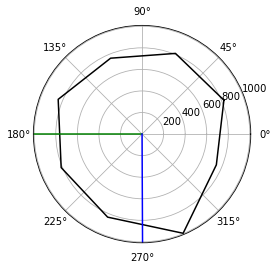

In [23]:
from brian2 import *
from brian2tools import *
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Parameters
degree = 2 * pi / 360.
duration = 500*ms
R = 2.5*cm  # radius of scorpion
vr = 50*meter/second  # Rayleigh wave speed
phi = 144*degree  # angle of prey
phi_1 = phi
A = 250*Hz
deltaI = .7*ms  # inhibitory delay
gamma = (22.5 + 45 * arange(8)) * degree  # leg angle
delay = R / vr * (1 - cos(phi - gamma))   # wave delay

# Inputs

# Wave (vector w)
time = arange(int(duration / defaultclock.dt) + 1) * defaultclock.dt
Dtot = 0.
w = 0.
for f in arange(150, 451)*Hz:
    D = exp(-(f/Hz - 300) ** 2 / (2 * (50 ** 2)))
    rand_angle = 2 * pi * rand()
    w += 100 * D * cos(2 * pi * f * time + rand_angle)
    Dtot += D
w = .01 * w / Dtot

# Rates from the wave
rates = TimedArray(w, dt=defaultclock.dt)

# Targets

# Leg mechanical receptors
print("SIMULATING LEG SPIKES FOR THE 4 TEST ANGLES: ")
print()
tau_legs = 1 * ms
sigma = .01
eqs_legs = """
dv/dt = (1 + rates(t - d) - v)/tau_legs + sigma*(2./tau_legs)**.5*xi:1
d : second
"""
fake_legs = NeuronGroup(8, model=eqs_legs, threshold='v > 1', reset='v = 0', refractory=1*ms, method='euler')
fake_legs.d = delay
fake_spikes_legs = SpikeMonitor(fake_legs)

# We use a Network object because later on we don't
# want to include these objects
leg_net = Network(fake_legs, fake_spikes_legs)
leg_net.store()
leg_net.run(duration, report ='text')
# And keep a copy of those spikes
spikes_i = fake_spikes_legs.i
spikes_t = fake_spikes_legs.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG_1 = SpikeGeneratorGroup(8, spikes_i, spikes_t)
leg_net.restore()

phi = 289*degree  # angle of prey
phi_2 = phi

# Wave (vector w)
time = arange(int(duration / defaultclock.dt) + 1) * defaultclock.dt
Dtot = 0.
w = 0.
for f in arange(150, 451)*Hz:
    D = exp(-(f/Hz - 300) ** 2 / (2 * (50 ** 2)))
    rand_angle = 2 * pi * rand()
    w += 100 * D * cos(2 * pi * f * time + rand_angle)
    Dtot += D
w = .01 * w / Dtot

# Rates from the wave
rates = TimedArray(w, dt=defaultclock.dt)

# Targets

leg_net.store()
leg_net.run(duration, report ='text')
# And keep a copy of those spikes
spikes_i = fake_spikes_legs.i
spikes_t = fake_spikes_legs.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG_2 = SpikeGeneratorGroup(8, spikes_i, spikes_t)
leg_net.restore()

phi = 25*degree  # angle of prey
phi_3 = phi

# Wave (vector w)
time = arange(int(duration / defaultclock.dt) + 1) * defaultclock.dt
Dtot = 0.
w = 0.
for f in arange(150, 451)*Hz:
    D = exp(-(f/Hz - 300) ** 2 / (2 * (50 ** 2)))
    rand_angle = 2 * pi * rand()
    w += 100 * D * cos(2 * pi * f * time + rand_angle)
    Dtot += D
w = .01 * w / Dtot

# Rates from the wave
rates = TimedArray(w, dt=defaultclock.dt)

# Targets

leg_net.store()
leg_net.run(duration, report ='text')
# And keep a copy of those spikes
spikes_i = fake_spikes_legs.i
spikes_t = fake_spikes_legs.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG_3 = SpikeGeneratorGroup(8, spikes_i, spikes_t)
leg_net.restore()

phi = 312*degree  # angle of prey
phi_4 = phi

# Wave (vector w)
time = arange(int(duration / defaultclock.dt) + 1) * defaultclock.dt
Dtot = 0.
w = 0.
for f in arange(150, 451)*Hz:
    D = exp(-(f/Hz - 300) ** 2 / (2 * (50 ** 2)))
    rand_angle = 2 * pi * rand()
    w += 100 * D * cos(2 * pi * f * time + rand_angle)
    Dtot += D
w = .01 * w / Dtot

# Rates from the wave
rates = TimedArray(w, dt=defaultclock.dt)

# Targets

leg_net.store()
leg_net.run(duration, report ='text')
# And keep a copy of those spikes
spikes_i = fake_spikes_legs.i
spikes_t = fake_spikes_legs.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG_4 = SpikeGeneratorGroup(8, spikes_i, spikes_t)
leg_net.restore()
print()

# Command neurons

model_weights = np.random.rand(64)

tau = 1 * ms
eqs_model = '''
dv/dt = (1-v)/tau : 1
'''

fake_neurons_1 = NeuronGroup(8, model=eqs_model, threshold='v>1', reset='v=0', method='exact')
fake_neurons_2 = NeuronGroup(8, model=eqs_model, threshold='v>1', reset='v=0', method='exact')
fake_neurons_3 = NeuronGroup(8, model=eqs_model, threshold='v>1', reset='v=0', method='exact')
fake_neurons_4 = NeuronGroup(8, model=eqs_model, threshold='v>1', reset='v=0', method='exact')
fake_synapses_1 = Synapses(SGG_1, fake_neurons_1, 'weight : 1',  on_pre='v_post += weight')
fake_synapses_2 = Synapses(SGG_2, fake_neurons_2, 'weight : 1',  on_pre='v_post += weight')
fake_synapses_3 = Synapses(SGG_3, fake_neurons_3, 'weight : 1',  on_pre='v_post += weight')
fake_synapses_4 = Synapses(SGG_4, fake_neurons_4, 'weight : 1',  on_pre='v_post += weight')
fake_synapses_1.connect()
fake_synapses_2.connect()
fake_synapses_3.connect()
fake_synapses_4.connect()
fake_synapses_1.weight = model_weights
fake_synapses_2.weight = model_weights
fake_synapses_3.weight = model_weights
fake_synapses_4.weight = model_weights
fake_spikes_1 = SpikeMonitor(fake_neurons_1)
fake_spikes_2 = SpikeMonitor(fake_neurons_2)
fake_spikes_3 = SpikeMonitor(fake_neurons_3)
fake_spikes_4 = SpikeMonitor(fake_neurons_4)

fake_1 = Network(SGG_1, fake_neurons_1, fake_synapses_1, fake_spikes_1)
fake_2 = Network(SGG_2, fake_neurons_2, fake_synapses_2, fake_spikes_2)
fake_3 = Network(SGG_3, fake_neurons_3, fake_synapses_3, fake_spikes_3)
fake_4 = Network(SGG_4, fake_neurons_4, fake_synapses_4, fake_spikes_4)

# loss function

def abs_err(target, model):
    delta = abs(target - model)
    delta_min = abs(target - model - 360)
    delta_plu = abs(target - model + 360)
    
    return min(set([delta, delta_min, delta_plu]))

def me(errors):
    mean_err = 0.
    for x in range(4):
        mean_err += errors[1]
    
    return mean_err/4

# storing origional state
fake_1.store()
fake_2.store()
fake_3.store()
fake_4.store()

errors = ([0.,0.,0.,0.])

# initial configuration
print('FINDING THE INTIAL MEAN ERROR:')
print()
fake_1.run(duration, report='text')
nspikes = fake_spikes_1.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi_1/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
errors[0] = abs_err((phi_1/degree), (phi_est/degree))
fake_1.restore()

fake_2.run(duration, report='text')
nspikes = fake_spikes_2.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi_2/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
errors[1] = abs_err((phi_2/degree), (phi_est/degree))
fake_2.restore()

fake_3.run(duration, report='text')
nspikes = fake_spikes_3.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi_3/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
errors[2] = abs_err((phi_3/degree), (phi_est/degree))
fake_3.restore()

fake_4.run(duration, report='text')
nspikes = fake_spikes_4.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi_4/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
errors[3] = abs_err((phi_4/degree), (phi_est/degree))
fake_4.restore()

me_err = me(errors)

print("Mean error (deg): %.2f" % me_err)
print()

print("RUNNING THE LEARNING ALGORITHM:")
print()
l_rate = 0.05
e = 0
for epoch in range(3):
    p = 0
    for s in fake_synapses_1.weight:
        
        # finding error with no change
        
        fake_1.run(duration)
        nspikes = fake_spikes_1.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[0] = abs_err((phi_1/degree), (phi_est/degree))
        fake_1.restore()

        fake_2.run(duration)
        nspikes = fake_spikes_2.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[1] = abs_err((phi_2/degree), (phi_est/degree))
        fake_2.restore()

        fake_3.run(duration)
        nspikes = fake_spikes_3.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[2] = abs_err((phi_3/degree), (phi_est/degree))
        fake_3.restore()

        fake_4.run(duration)
        nspikes = fake_spikes_4.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[3] = abs_err((phi_4/degree), (phi_est/degree))
        fake_4.restore()

        me_err = me(errors)

        # attempt adding learning rate
        
        fake_synapses_1.weight[p] += l_rate
        fake_synapses_2.weight[p] += l_rate
        fake_synapses_3.weight[p] += l_rate
        fake_synapses_4.weight[p] += l_rate

        fake_1.run(duration)
        nspikes = fake_spikes_1.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[0] = abs_err((phi_1/degree), (phi_est/degree))
        fake_1.restore()

        fake_2.run(duration)
        nspikes = fake_spikes_2.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[1] = abs_err((phi_2/degree), (phi_est/degree))
        fake_2.restore()

        fake_3.run(duration)
        nspikes = fake_spikes_3.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[2] = abs_err((phi_3/degree), (phi_est/degree))
        fake_3.restore()

        fake_4.run(duration)
        nspikes = fake_spikes_4.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[3] = abs_err((phi_4/degree), (phi_est/degree))
        fake_4.restore()

        add_me_err = me(errors)

        # attempt subtracting learning rate
        
        fake_synapses_1.weight[p] -= l_rate
        fake_synapses_2.weight[p] -= l_rate
        fake_synapses_3.weight[p] -= l_rate
        fake_synapses_4.weight[p] -= l_rate

        fake_1.run(duration)
        nspikes = fake_spikes_1.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[0] = abs_err((phi_1/degree), (phi_est/degree))
        fake_1.restore()

        fake_2.run(duration)
        nspikes = fake_spikes_2.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[1] = abs_err((phi_2/degree), (phi_est/degree))
        fake_2.restore()

        fake_3.run(duration)
        nspikes = fake_spikes_3.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[2] = abs_err((phi_3/degree), (phi_est/degree))
        fake_3.restore()

        fake_4.run(duration)
        nspikes = fake_spikes_4.count
        phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
        errors[3] = abs_err((phi_4/degree), (phi_est/degree))
        fake_4.restore()

        sub_me_err = me(errors)

        min_err = min(set([me_err, add_me_err, sub_me_err]))

        if(min_err == add_me_err):
            fake_synapses_1.weight[p] += l_rate
            fake_synapses_2.weight[p] += l_rate
            fake_synapses_3.weight[p] += l_rate
            fake_synapses_4.weight[p] += l_rate
        if(min_err == sub_me_err):
            fake_synapses_1.weight[p] -= l_rate
            fake_synapses_2.weight[p] -= l_rate
            fake_synapses_3.weight[p] -= l_rate
            fake_synapses_4.weight[p] -= l_rate

        # storing new initial state
        fake_1.store()
        fake_2.store()
        fake_3.store()
        fake_4.store()
        
        p = p + 1   

    print('epoch %i:' % e)
    fake_1.run(duration, report='text')
    nspikes = fake_spikes_1.count
    phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
    print("True angle (deg): %.2f" % (phi_1/degree))
    print("Estimated angle (deg): %.2f" % (phi_est/degree))
    errors[0] = abs_err((phi_1/degree), (phi_est/degree))
    fake_1.restore()

    fake_2.run(duration, report='text')
    nspikes = fake_spikes_2.count
    phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
    print("True angle (deg): %.2f" % (phi_2/degree))
    print("Estimated angle (deg): %.2f" % (phi_est/degree))
    errors[1] = abs_err((phi_2/degree), (phi_est/degree))
    fake_2.restore()

    fake_3.run(duration, report='text')
    nspikes = fake_spikes_3.count
    phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
    print("True angle (deg): %.2f" % (phi_3/degree))
    print("Estimated angle (deg): %.2f" % (phi_est/degree))
    errors[2] = abs_err((phi_3/degree), (phi_est/degree))
    fake_3.restore()

    fake_4.run(duration, report='text')
    nspikes = fake_spikes_4.count
    phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
    print("True angle (deg): %.2f" % (phi_4/degree))
    print("Estimated angle (deg): %.2f" % (phi_est/degree))
    errors[3] = abs_err((phi_4/degree), (phi_est/degree))
    fake_4.restore()

    me_err = me(errors)

    print("Mean error (deg): %.2f" % me_err)
    print()
    
    e = e + 1

# testing network on new angle
print("TESTING NETWORK ON NEW ANGLE:")
    
phi = 180*degree  # angle of prey
phi_5 = phi

# Wave (vector w)
time = arange(int(duration / defaultclock.dt) + 1) * defaultclock.dt
Dtot = 0.
w = 0.
for f in arange(150, 451)*Hz:
    D = exp(-(f/Hz - 300) ** 2 / (2 * (50 ** 2)))
    rand_angle = 2 * pi * rand()
    w += 100 * D * cos(2 * pi * f * time + rand_angle)
    Dtot += D
w = .01 * w / Dtot

# Rates from the wave
rates = TimedArray(w, dt=defaultclock.dt)

leg_net.store()
leg_net.run(duration, report ='text')
# And keep a copy of those spikes
spikes_i = fake_spikes_legs.i
spikes_t = fake_spikes_legs.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG_5 = SpikeGeneratorGroup(8, spikes_i, spikes_t)
leg_net.restore()

fake_neurons_5 = NeuronGroup(8, model=eqs_model, threshold='v>1', reset='v=0', method='exact')
fake_synapses_5 = Synapses(SGG_5, fake_neurons_5, 'weight : 1',  on_pre='v_post += weight')
fake_synapses_5.connect()
fake_synapses_5.weight = fake_synapses_4.weight
fake_spikes_5 = SpikeMonitor(fake_neurons_5)

fake_5 = Network(SGG_5, fake_neurons_5, fake_synapses_5, fake_spikes_5) 

fake_5.run(duration, report='text')
nspikes = fake_spikes_5.count
phi_est = imag(log(sum(nspikes * exp(gamma * 1j))))
print("True angle (deg): %.2f" % (phi_5/degree))
print("Estimated angle (deg): %.2f" % (phi_est/degree))
error = abs_err((phi_5/degree), (phi_est/degree))
print("Error (deg): %.2f" % error)
    
rmax = amax(nspikes)/duration/Hz
polar(concatenate((gamma, [gamma[0] + 2 * pi])),
      concatenate((nspikes, [nspikes[0]])) / duration / Hz,
      c='k')
axvline(phi_5, ls='-', c='g')
axvline(phi_est, ls='-', c='b')
show()